In [1]:

import os
import sys
import matplotlib.pyplot as plt


plt.close('all');
os.system('clear')
os.system('cls')


############################## ADD CODE PATH ##############################
sys.path.append(os.path.join(os.path.expanduser('~'),  'Documents', 'Projects','dMRS_starting_data_cristina','dMRSI','processing_dmrs'))
sys.path.append(os.path.join(os.path.expanduser('~'),  'Documents', 'Projects','dMRS_starting_data_cristina','dMRSI'))


import importlib, sys
from custom_functions import *
from bids_structure import *
importlib.reload(sys.modules['custom_functions'])
importlib.reload(sys.modules['bids_structure'])
from Step1_Fitting import *

########################## DATA PATH AND SUBJECTS ##########################
subj_list = ['sub-01','sub-02','sub-03']

cfg                         = {}
cfg['data_path']            = os.path.join(os.path.expanduser('~'), 'Documents','Projects','dMRS_starting_data_cristina','CristinasTestData')
cfg['prep_foldername']      = 'preprocessed'
cfg['analysis_foldername']  = 'analysis_callaghan'
cfg['common_folder']        = os.path.join(os.path.expanduser('~'), 'Documents','Projects','dMRS_starting_data_cristina','common')


sh: 1: cls: not found


In [2]:
data_path   = cfg['data_path']
scan_list   = pd.read_excel(os.path.join(data_path, 'ScanList.xlsx'))

In [ ]:

subj = subj_list[0]

print('Fitting MRS of ' + subj + '...')

# Extract data for subject
subj_data      = scan_list[(scan_list['newstudyName'] == subj)].reset_index(drop=True)

# List of acquisition sessions
sess_list    = [x for x in list(subj_data['blockNo'].unique()) if not math.isnan(x)] # clean NaNs

######## SESSION-WISE OPERATIONS ########
sess=sess_list[0]

# Read data
bids_strc = create_bids_structure(subj=subj, sess=sess, datatype='dmrs', root=data_path,
                                            folderlevel='derivatives', workingdir='preprocessed')
basis_filename = os.path.join(cfg['common_folder'],'mrs_basis')
dyn_filename   = os.path.join(cfg['common_folder'],'mrs_dyn_config_multi.py')

In [11]:


data_filename  = bids_strc.get_path('dmrs.nii.gz')
data           = mrs_io.read_FID(data_filename)
dmrs_list      = data.mrs(basis_file=basis_filename)
bvals          = data.dynamic_hdr_vals()[-1].flatten().astype(float)

bvals_filename = bids_strc.get_path('bvals')
new_filename   = bids_strc.get_path('dmrs_lowb.nii.gz')



FileNotFoundError: No such file or no access: '/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis/sub-01/ses-01/dmrs/dyn_fit/sub-01_ses-01_dyn_fit_dmrs.nii.gz'

In [12]:
sys.path.append(cfg['common_folder'])
from mrs_dyn_config_multi import *

In [66]:
def model_biexp(p,t):
    # p = [amp,adc1,adc2,frac]
    return p[0]*(p[3]*exp(-p[1]*t)+(1-p[3])*exp(-p[2]*t))

def model_callaghan(p, t):
    # p = [amp, adc]
    sqrtbD = sqrt(t*p[1])
    return p[0]*sqrt(pi)/(2*sqrtbD)*erf(sqrtbD)

def model_callaghan_grad(p, t):
    bD = t*p[1]
    sqrtbD = sqrt(bD)
    erfsqrtbD = erf(sqrtbD)
    g0 = sqrt(pi)/(2*sqrtbD)*erfsqrtbD
    g1 = p[0]*(exp(-bD)  / (2 * p[1]) - sqrt(pi)*t*erfsqrtbD / (4*(t*p[1])**(3/2)))
    return asarray([g0, g1], dtype=object)
def model_biexp_grad(p,t):
    e1 = exp(-p[1]*t)
    e2 = exp(-p[2]*t)
    g0 = p[3]*e1+(1-p[3])*e2
    g1 = p[0]*(-p[3]*t*e1)
    g2 = p[0]*(-(1-p[3])*t*e2)
    g3 = p[0]*(e1-e2)
    return asarray([g0,g1,g2,g3])

In [67]:
from matplotlib import pyplot as plt

In [68]:
p_biexp = [1, .5, .5, 0.8]
p_callaghan = [1, 2]

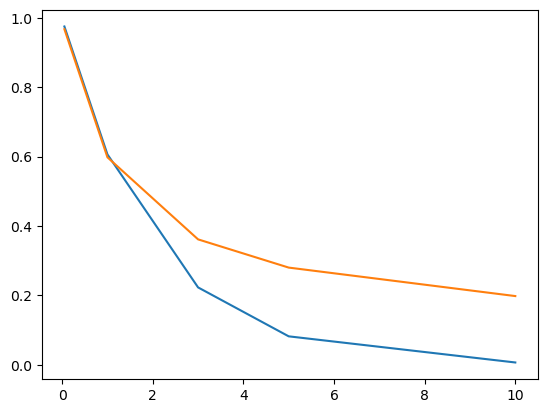

In [69]:
plt.plot(bvals,model_biexp(p_biexp,bvals))
plt.plot(bvals,model_callaghan(p_callaghan,bvals))

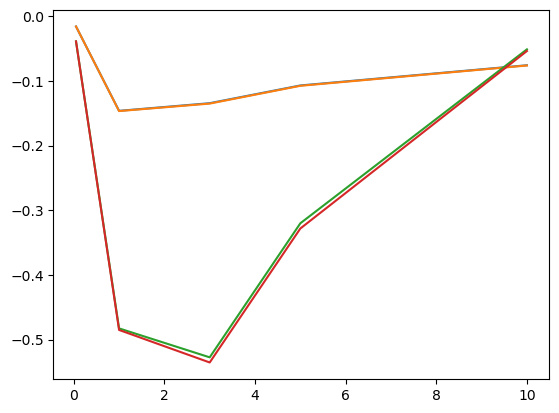

In [70]:
D_base = 1.5
p_callaghan = [1, D_base]
p_callaghan_inc = [1, D_base+.01]

p_biexp = [1, .5, .5, 0.8]
p_biexp_inc = [1, .5+.01, .5, 0.8]


plt.plot(bvals,(model_callaghan(p_callaghan_inc,bvals)-model_callaghan(p_callaghan,bvals))/.01)
plt.plot(bvals,model_callaghan_grad(p_callaghan,bvals)[1])

plt.plot(bvals,(model_biexp(p_biexp_inc,bvals)-model_biexp(p_biexp,bvals))/.01)
plt.plot(bvals, model_biexp_grad(p_biexp,bvals)[1])



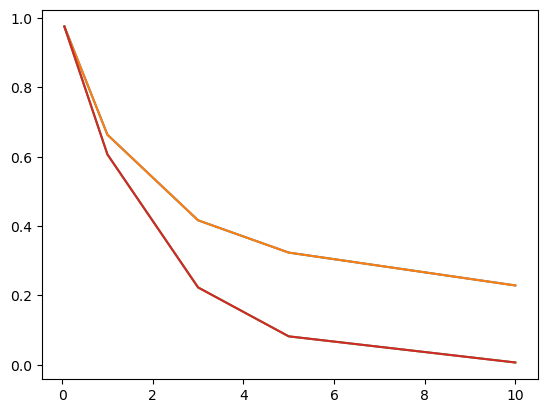

In [78]:
A_base = 1.5
inc=1
p_callaghan = [A_base, D_base]
p_callaghan_inc = [A_base+inc, D_base]

p_biexp = [A_base, .5, .5, 0.8]
p_biexp_inc = [A_base+inc, .5, .5, 0.8]


plt.plot(bvals,(model_callaghan(p_callaghan_inc,bvals)-model_callaghan(p_callaghan,bvals))/inc)
plt.plot(bvals,model_callaghan_grad(p_callaghan,bvals)[0])

plt.plot(bvals,(model_biexp(p_biexp_inc,bvals)-model_biexp(p_biexp,bvals))/inc)
plt.plot(bvals, model_biexp_grad(p_biexp,bvals)[0])



In [72]:

## 2. Dynamic fit - option 2 (using fsl mrs command line)

# Create output path
bids_strc.set_param(workingdir='analysis', description='dyn_fit')
out_path    = bids_strc.get_path()

# Check that the basis has the right phase/frequency convention
for mrs in dmrs_list:
    mrs.check_Basis(repair=True)

# write b vals file
with open(bvals_filename, 'w') as file:
    for element in bvals:
        file.write(f"{element} ")


call= [f'fsl_dynmrs',
        f'--data {data_filename}',
        f'--basis {basis_filename}',
        f'--dyn_config {dyn_filename}',
        f'--time_variables {bvals_filename}',
        f'--lorentzian',
        f'--baseline_order 1',
        f'--metab_groups "Mac"',
        f'--output {out_path}',
        f'--report',
        f'--overwrite']

print(' '.join(call))
os.system(' '.join(call))


fsl_dynmrs --data /home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis/sub-01/ses-01/dmrs/dyn_fit/sub-01_ses-01_dyn_fit_dmrs.nii.gz --basis /home/malte/Documents/Projects/dMRS_starting_data_cristina/common/mrs_basis --dyn_config /home/malte/Documents/Projects/dMRS_starting_data_cristina/common/mrs_dyn_config_multi.py --time_variables /home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/preprocessed/sub-01/ses-01/dmrs/sub-01_ses-01_bvals --lorentzian --baseline_order 1 --metab_groups "Mac" --output /home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis/sub-01/ses-01/dmrs/dyn_fit --report --overwrite


Traceback (most recent call last):
  File "/home/malte/fsl/lib/python3.12/site-packages/nibabel/loadsave.py", line 101, in load
    stat_result = os.stat(filename)
                  ^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/analysis/sub-01/ses-01/dmrs/dyn_fit/sub-01_ses-01_dyn_fit_dmrs.nii.gz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/malte/fsl/bin/fsl_dynmrs", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/malte/fsl/lib/python3.12/site-packages/fsl_mrs/scripts/fsl_dynmrs.py", line 162, in main
    data = mrs_io.read_FID(args.data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/malte/fsl/lib/python3.12/site-packages/fsl_mrs/utils/mrs_io/main.py", line 101, in read_FID
    return fsl.readNIFTI(filename)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/malte/

256

In [ ]:


            ## 1. Simple fit - first b value - option 2 (using fsl mrs command line)

            # Create output path
            bids_strc.set_param(workingdir='analysis', description='single_fit')
            out_path    = bids_strc.get_path()

            data_to_fit, _ = ntools.split(data, dimension='DIM_USER_0',index_or_indices=0)
            data_to_fit.set_dim_tag('DIM_USER_0', 'DIM_DYN')
            data_to_fit.save(new_filename)

            call= [f'fsl_mrs',
                       f'--data {new_filename}',
                       f'--basis {basis_filename}',
                       f'--lorentzian',
                       f'--metab_groups "Mac"',
                       f'--output {out_path}',
                       f'--report',
                       f'--overwrite']

            print(' '.join(call))
            os.system(' '.join(call))



            ## 2. Dynamic fit - option 1 (using python fsl)
            # to be improved

            # Create output path
           #  bids_strc.set_param(workingdir='analysis', description='dyn_fit')
           #  out_path    = bids_strc.get_path()

           #  # Check that the basis has the right phase/frequency convention
           #  for mrs in dmrs_list:
           #      mrs.check_Basis(repair=True)

           #  Fitargs = {'ppmlim': (0.2, 5.0),
           #             'baseline_order': 1,
           #             'metab_groups': parse_metab_groups(dmrs_list, 'Mac'),
           #              'model': 'lorentzian'}
           #  dobj = dyn.dynMRS(
           #          dmrs_list,
           #          bvals,
           #          config_file={dyn_filename},
           #          rescale=True,
           #          **Fitargs)


           #  dres = dobj.fit()
           # # _ = dres.plot_mapped()
           #  splot.plotly_dynMRS(dmrs_list, dres.reslist, dobj.time_var)


In [39]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
real_data_processed=data_processed['study'][0,0]['data'][0,0]['real'][:,0,:]
real_data_processed_sum=np.sum(real_data_processed,axis=1)
imag_data_processed=data_processed['study'][0,0]['data'][0,0]['imag'][:,0,:]
imag_data_processed_sum=np.sum(imag_data_processed,axis=1)
absolute_data_processed = np.absolute(real_data_processed+1j*imag_data_processed)
absolute_data_processed_sum = np.sum(absolute_data_processed,axis=1)

In [60]:
real_data_raw=data_raw['study'][0,0]['data'][0,0]['real'][:,0,:]
real_data_raw_sum=np.sum(real_data_raw,axis=1)
imag_data_raw=data_raw['study'][0,0]['data'][0,0]['imag'][:,0,:]
imag_data_raw_sum=np.sum(imag_data_raw,axis=1)
absolute_data_raw = np.absolute(real_data+1j*imag_data)
absolute_data_raw_sum = np.sum(absolute_data,axis=1)

In [69]:
real_data_sum=data_sum['study'][0,0]['data'][0,0]['real'][:,0,:][0]
imag_data_sum=data_sum['study'][0,0]['data'][0,0]['imag'][:,0,:][0]
absolute_data_sum= np.absolute(real_data_sum+1j*imag_data_sum)

In [70]:

absolute_data_sum.shape

(4096,)

(0.0, 500.0)

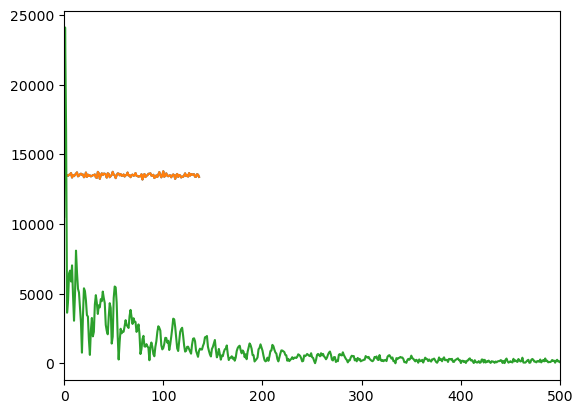

In [84]:
i=3
plt.plot(absolute_data_processed_sum)
plt.plot(absolute_data_raw_sum)
plt.plot(absolute_data_sum)
plt.xlim(0,500)